
🚀 Test avec StandardScaler + Config = Baseline
   Fold 1 | Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 6} | F1 = 0.9988 | ⏱️ 45.26s
   Fold 2 | Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 6} | F1 = 0.9990 | ⏱️ 44.98s
   Fold 3 | Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 6} | F1 = 0.9979 | ⏱️ 44.61s
   Fold 4 | Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 6} | F1 = 0.9993 | ⏱️ 45.16s
   Fold 5 | Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 6} | F1 = 0.9982 | ⏱️ 44.38s
   ➡️ Moyenne F1 CV = 0.9986 ± 0.0005
📊 Test final | Accuracy = 0.9983, F1 = 0.9983, ROC-AUC = 0.9991

🚀 Test avec StandardScaler + Config = Deep Trees
   Fold 1 | Params: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10} | F1 = 0.9985 | ⏱️ 70.13s
   Fold 2 | Params: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10} | F1 = 0.9987 | ⏱️ 71.04s
   Fold 3 | Params: {'n_estimators': 300, 'learning_ra

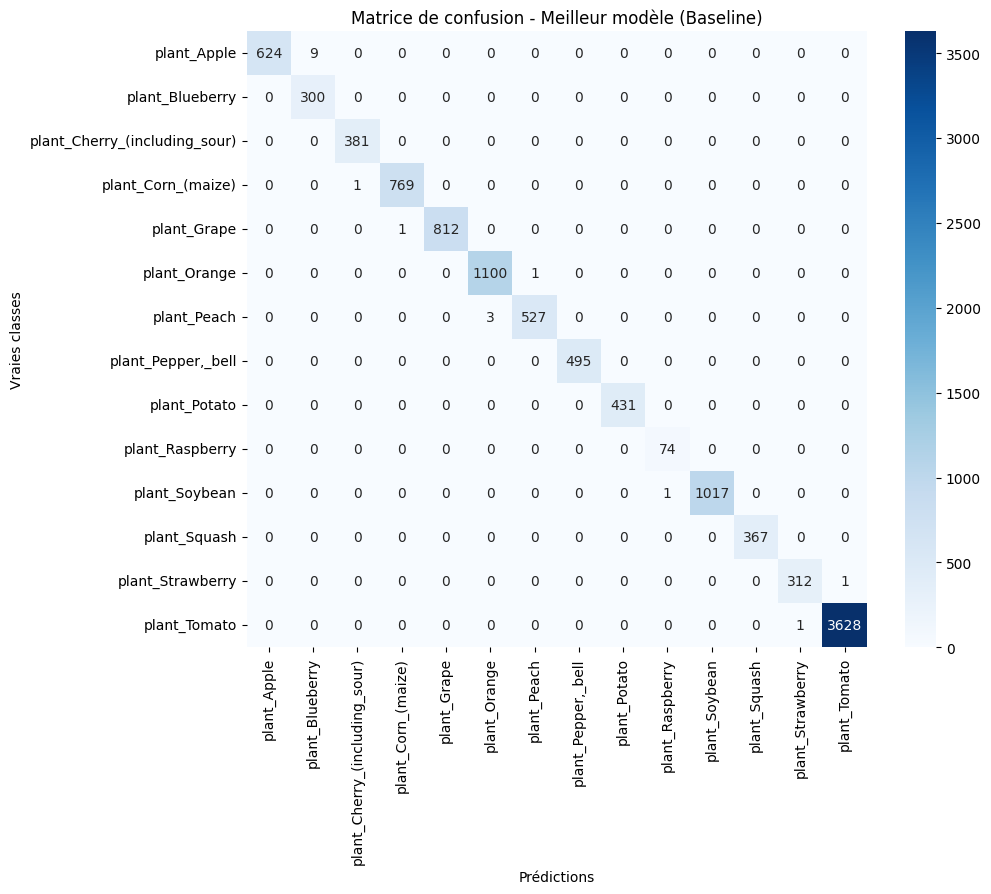

In [5]:
# ------------------------------------------------------
# IMPORT DES LIBRAIRIES
# ------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, time
warnings.filterwarnings("ignore")

# ------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------

FEATURES_PATH = "/workspaces/datasciencetest_reco_plante/dataset/plantvillage/csv/clean_with_features_data_plantvillage_segmented_all.csv"
SEED = 42  # graine aléatoire pour reproductibilité

# ------------------------------------------------------
# DÉTECTION AUTOMATIQUE DES COLONNES PLANTES (labels)
# ------------------------------------------------------
plant_columns = [col for col in pd.read_csv(FEATURES_PATH, nrows=1).columns if col.startswith("plant_")]

# ------------------------------------------------------
# CHARGEMENT DU DATASET
# ------------------------------------------------------
df = pd.read_csv(FEATURES_PATH)

# ------------------------------------------------------
# SUPPRESSION DES VALEURS MANQUANTES (NaN)
# ------------------------------------------------------
numeric_columns = df.drop(columns=plant_columns).select_dtypes(include=np.number).columns
df = df.dropna(subset=numeric_columns.tolist() + plant_columns)

# ------------------------------------------------------
# PRÉPARATION DES DONNÉES
# ------------------------------------------------------
X = df[numeric_columns].values
y = df[plant_columns].values
y = np.argmax(y, axis=1)

# ------------------------------------------------------
# NORMALISATION
# ------------------------------------------------------
scalers = {"StandardScaler": StandardScaler()}

# ------------------------------------------------------
# CONFIGURATIONS XGBOOST
# ------------------------------------------------------
configs = {
    "Baseline": {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 6},
    "Deep Trees": {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 10},
    "Shallow Trees": {"n_estimators": 500, "learning_rate": 0.01, "max_depth": 3}
}

# ------------------------------------------------------
# FONCTION D'ÉVALUATION
# ------------------------------------------------------
def evaluate(y_true, y_pred, dataset_name="Test"):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    try:
        auc = roc_auc_score(pd.get_dummies(y_true), pd.get_dummies(y_pred), average="weighted")
    except:
        auc = None
    print(f"📊 {dataset_name} | Accuracy = {acc:.4f}, F1 = {f1:.4f}", end="")
    if auc is not None:
        print(f", ROC-AUC = {auc:.4f}")
    else:
        print(" (ROC-AUC non calculable - multi-classes)")
    return acc, f1, auc

# ------------------------------------------------------
# BOUCLE PRINCIPALE : SCALERS + CONFIGS + VALIDATION CROISÉE
# ------------------------------------------------------
results = []

for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=SEED
    )

    for config_name, params in configs.items():
        print(f"\n🚀 Test avec {scaler_name} + Config = {config_name}")

        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric="mlogloss",
            random_state=SEED,
            **params
        )

        # Validation croisée 5-fold stratifiée
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        f1_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            # SMOTE pour rééquilibrer les classes minoritaires
            smote = SMOTE(random_state=SEED)
            X_tr_bal, y_tr_bal = smote.fit_resample(X_tr, y_tr)

            # Entraînement du modèle
            start_time = time.time()
            model.fit(X_tr_bal, y_tr_bal)
            elapsed_time = time.time() - start_time

            # Prédiction sur le fold de validation
            y_val_pred = model.predict(X_val)
            f1_fold = f1_score(y_val, y_val_pred, average="weighted")
            f1_scores.append(f1_fold)
            print(f"   Fold {fold+1} | Params: {params} | F1 = {f1_fold:.4f} | ⏱️ {elapsed_time:.2f}s")

        print(f"   ➡️ Moyenne F1 CV = {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

        # Réentraînement sur tout le train avec SMOTE
        smote = SMOTE(random_state=SEED)
        X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
        model.fit(X_train_bal, y_train_bal)

        # Évaluation finale sur le test set
        y_test_pred = model.predict(X_test)
        acc, f1, auc = evaluate(y_test, y_test_pred, dataset_name="Test final")

        # Stockage des résultats
        results.append({
            "Scaler": scaler_name,
            "Config": config_name,
            "CV_F1_mean": np.mean(f1_scores),
            "CV_F1_std": np.std(f1_scores),
            "Test_Accuracy": acc,
            "Test_F1": f1,
            "Test_AUC": auc
        })

# ------------------------------------------------------
# AFFICHAGE DES RÉSULTATS FINAUX
# ------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n📊 Tableau comparatif des résultats :")
print(results_df)

# ------------------------------------------------------
# MATRICE DE CONFUSION
# ------------------------------------------------------
best_model_idx = results_df['Test_F1'].idxmax()
best_config_name = results_df.iloc[best_model_idx]['Config']
print(f"\n🏆 Meilleure configuration : {best_config_name}")

# Réentraînement du meilleur modèle sur tout le train + SMOTE
best_params = configs[best_config_name]
best_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=SEED,
    **best_params
)
X_train_bal, y_train_bal = SMOTE(random_state=SEED).fit_resample(X_train, y_train)
best_model.fit(X_train_bal, y_train_bal)

# Prédiction sur le test set
y_test_pred = best_model.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=plant_columns, yticklabels=plant_columns, cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title(f"Matrice de confusion - Meilleur modèle ({best_config_name})")
plt.show()
